In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)

from mat_models import MR
from node_utils import init_params, NODE_model
from utils import train_jp, eval_Cauchy
from diffusion_utils import *

/opt/homebrew/lib/python3.9/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(4, 5, 6), but only accepts 6 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


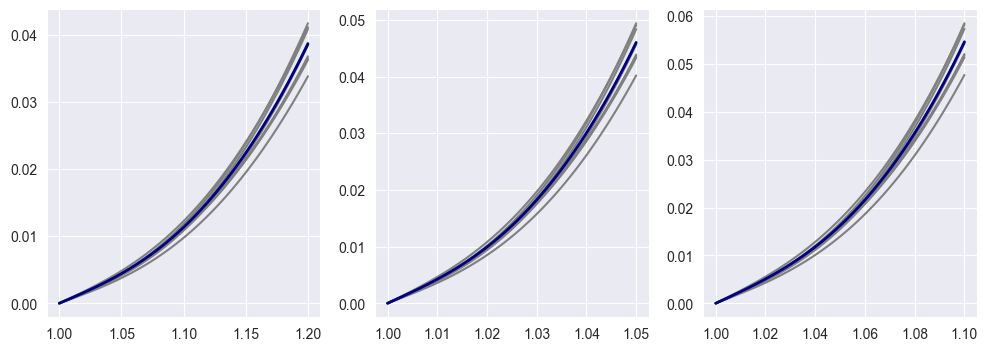

In [2]:
# Generate training data from Mooney Rivlin
MR_params  = [0.01,         0.01,         0.14424528] # baseline params
# do for Mooney because it is isotropic so better 
J = 10 # 10 different samples 
ps = random.normal(rng,shape=(J,len(MR_params)))
MR_params_s = np.zeros((J,len(MR_params)))
for i in range(J):
    for j in range(len(MR_params)):
        MR_params_s[i,j] = MR_params[j]*np.exp(0.1*ps[i,j])

# Given thse parameters, generate bunch of curves for different tests
# and plot to see. All biaxial, just different type of biaxial 
lam_ls = np.linspace(1,1.2,50)
# 3 different biaxial deformations going from strip biax, to off, 
# to equi-biaxial 
lam_vec = np.zeros((3*50,2))
for i in range(3):
    alpha = i/4
    lam_vec[i*50:(i+1)*50,0] = 1+alpha*(lam_ls-1)
    lam_vec[i*50:(i+1)*50,1] = 1+(1-alpha)*(lam_ls-1)
# mean response
sigma_MR_m     = MR(MR_params).sigma(lam_vec)
# all 10 samples
sigma_MR_s = []
for j in range(10):
    sigma_MR_si = MR(MR_params_s[j]).sigma(lam_vec)
    sigma_MR_s.append(sigma_MR_si)

# plot
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

for j in range(10):
    axs[0].plot(lam_vec[:50,1],         sigma_MR_s[j][0][:50]       ,color='grey')
    axs[1].plot(lam_vec[50:2*50,0],     sigma_MR_s[j][0][50:2*50]   ,color='grey')
    axs[2].plot(lam_vec[2*50:3*50,0],   sigma_MR_s[j][0][2*50:3*50] ,color='grey')

axs[0].plot(lam_vec[:50,1],         sigma_MR_m[0][:50]      ,color='navy',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     sigma_MR_m[0][50:2*50]  ,color='navy',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   sigma_MR_m[0][2*50:3*50],color='navy',linewidth=2)

In [3]:
# Restructure the stress-stretch data a bit
lamx_all,   lamy_all    = np.array([lam_vec]*J).reshape([-1,2]).T     # Repeat the same lmx & lmy values J times
sigmax_all, sigmay_all  = np.array(sigma_MR_s).transpose([1,0,2]).reshape([2,-1])
lamb_sigma = np.vstack([lamx_all,lamy_all,sigmax_all,sigmay_all]).transpose()

## just the mean response
sigmax_r = lamb_sigma[:,2].reshape((10,150))
sigma_x_m = np.mean(sigmax_r,axis=0)
sigmay_r = lamb_sigma[:,3].reshape((10,150))
sigma_y_m = np.mean(sigmay_r,axis=0)
lamb_sigma_m = np.vstack([lam_vec[:,0],lam_vec[:,1],sigma_x_m,sigma_y_m]).transpose()

In [4]:
# Normalization factors
I1_factor = 3
I2_factor = 3
Psi1_factor = 1.0
Psi2_factor = 1.0
Psi_1_2_factor = 1.0
normalization = [I1_factor, I2_factor, Psi1_factor, Psi2_factor, Psi_1_2_factor]

# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, normalization):
    # params come with all the common parameters first
    params_I1, params_I2, params_I1I2 = params

    model   = NODE_model(params_I1, params_I2, params_I1I2)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sigmax  = lamb_sigma[:,2]
    sigmay  = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, 5, 5]
sample_layers = [5,1]
params_all = init_params(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_all)

# Train
params_all, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma_m, normalization, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=10000)

it 10000, train loss = 5.667998e-05


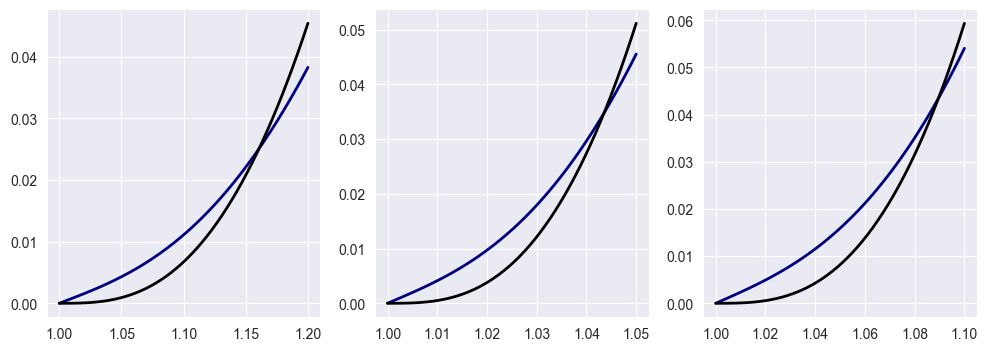

In [5]:
mymodel = NODE_model(*params_all)
# plot
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

axs[0].plot(lam_vec[:50,1],         lamb_sigma_m[:50,2],        color='navy',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     lamb_sigma_m[50:2*50,2],    color='navy',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   lamb_sigma_m[2*50:3*50,2],  color='navy',linewidth=2)

sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)
axs[0].plot(lam_vec[:50,1],         sigx[:50],      color='k',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     sigx[50:2*50],  color='k',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   sigx[2*50:3*50],color='k',linewidth=2)

In [6]:
# fit individually 
params_I1, params_I2, params_I1I2 = params_all
params_I1c,params_I1s_m = params_I1
params_I2c,params_I2s_m = params_I2
params_I1I2c,params_I1I2s_m,params_I1I2_a = params_I1I2

# loss_sample = lambda mean_sample_params, X, normalization: loss_sig_all( ((params_I1c,mean_sample_params[0]),(params_I2c,mean_sample_params[1]),(params_I1I2c,mean_sample_params[2],params_I1I2_a)), X, normalization)
def loss_sample(sample_params, X, normalization): #This keeps the common params constant and varies sample_params
    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    params_I1I2 = (params_I1I2c, sample_params[2], params_I1I2_a)
    params = (params_I1, params_I2, params_I1I2)
    return loss_sig_all(params, X, normalization)

mean_sample_params = (params_I1s_m,params_I2s_m,params_I1I2s_m)

Sample_params = []

for j in range(10):
    sigx = sigma_MR_s[j][0]
    sigy = sigma_MR_s[j][1]
    lamb_sigma_j = np.vstack([lam_vec[:,0],lam_vec[:,1],sigx,sigy]).transpose()
    opt_init, opt_update, get_params = optimizers.adam(1e-3)
    opt_state = opt_init(mean_sample_params)

    sample_params, train_loss, val_loss = train_jp(loss_sample, lamb_sigma_j, normalization, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=10000)
    Sample_params.append(sample_params)

it 1000, train loss = 5.567543e-05
it 1000, train loss = 5.075245e-05
it 1000, train loss = 4.310290e-05
it 1000, train loss = 5.304255e-05
it 1000, train loss = 5.934490e-05
it 1000, train loss = 6.061137e-05
it 1000, train loss = 7.267434e-05
it 1000, train loss = 6.260164e-05
it 1000, train loss = 5.736680e-05
it 1000, train loss = 5.401483e-05


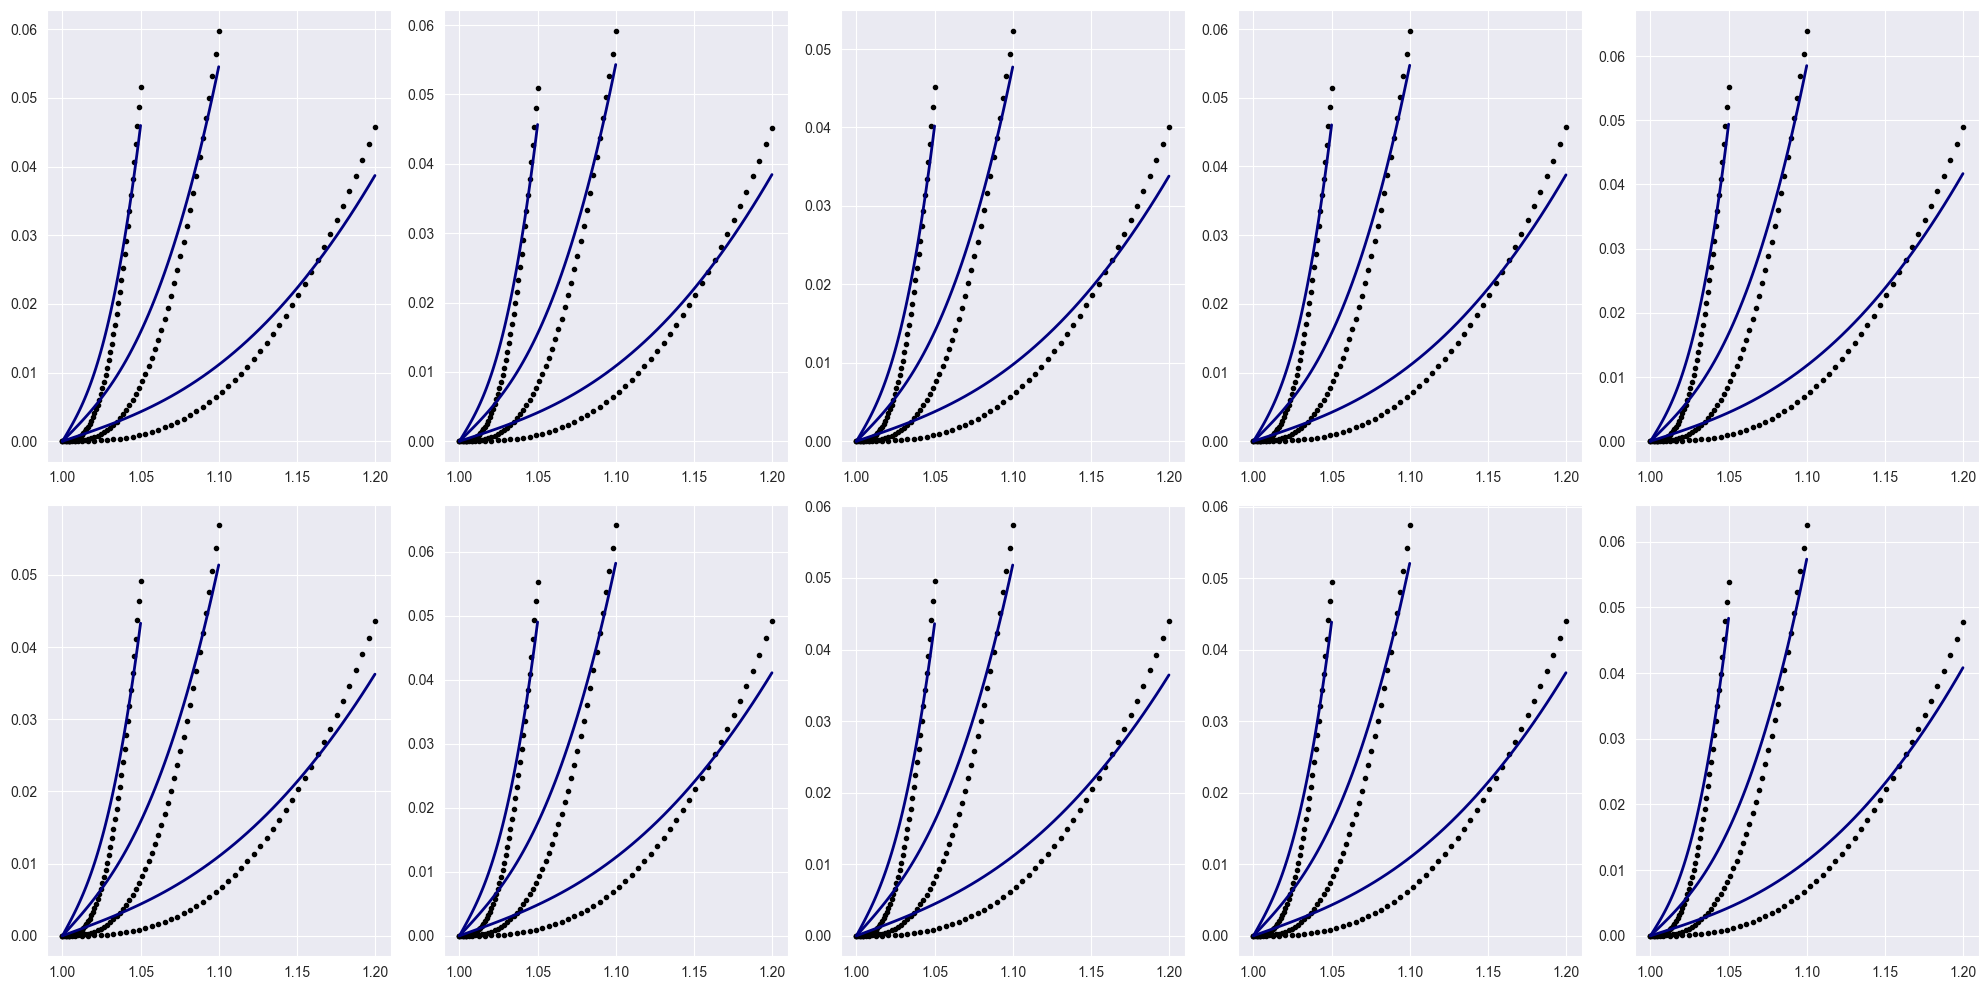

In [7]:
plt.figure(figsize = (20,10))
for i, sample_params in enumerate(Sample_params):
    params_I1si,params_I2si, params_I1I2si = sample_params 
    params_I1 = (params_I1c, params_I1si)
    params_I2 = (params_I2c, params_I2si)
    params_I1I2 = (params_I1I2c, params_I1I2si, params_I1I2_a)

    mymodel = NODE_model(params_I1,params_I2,params_I1I2)
    sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)
    sigx_gt = sigma_MR_s[i][0]
    sigy_gt = sigma_MR_s[i][1]

    plt.subplot(2,5,i+1)

    plt.plot(lam_vec[:50,1],        sigx[:50],      'k.',linewidth=2)
    plt.plot(lam_vec[50:2*50,0],    sigx[50:2*50],  'k.',linewidth=2)
    plt.plot(lam_vec[2*50:3*50,0],  sigx[2*50:3*50],'k.',linewidth=2)

    plt.plot(lam_vec[:50,1],        sigx_gt[:50],       color='navy',linewidth=2)
    plt.plot(lam_vec[50:2*50,0],    sigx_gt[50:2*50],   color='navy',linewidth=2)
    plt.plot(lam_vec[2*50:3*50,0],  sigx_gt[2*50:3*50], color='navy',linewidth=2)
plt.tight_layout()

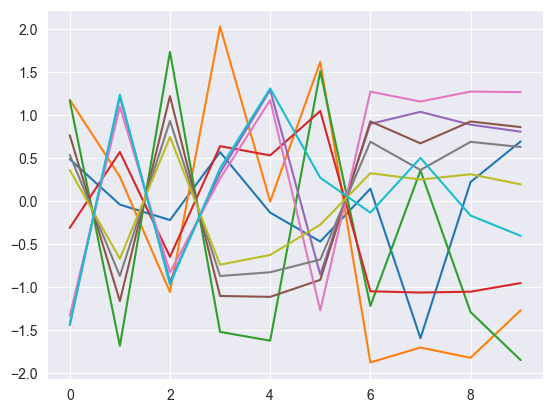

In [8]:
w_diffusion = np.array([ravel_pytree(sample_params)[0] for sample_params in Sample_params])
unravel_params = ravel_pytree(Sample_params[0])[1]

w_diffusion_I1_I2 = w_diffusion[:,0:10] # because we are note using I1-I2
mu_x  = jnp.mean(w_diffusion_I1_I2,0)
std_x = jnp.std (w_diffusion_I1_I2,0)
w_diffusion_scaled = (w_diffusion_I1_I2-mu_x)/std_x

for l in w_diffusion_scaled:
    plt.plot(l)


# Save for tikz
np.savetxt('tikz/fig_diagram_data/w_dist.csv', X=np.vstack([np.arange(10),w_diffusion_scaled]).T, delimiter=' ', header='x y1 y2 y3 y4 y5 y6 y7 y8 y9 y10', comments='')

# Save the random noise data while you are at it
x = np.arange(20)
y = np.random.normal(size=20*100).reshape(100,20)
header = 'x'
for i in range(100):
    header = header + ' y' + str(i)
np.savetxt('tikz/fig_diagram_data/random_noise.csv', X=np.vstack([x,y]).T, delimiter=' ', header=header, comments='')

#### Diffusion

In [13]:
batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils
#Initialize the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

In [15]:
N_epochs = 2_000
train_size = w_diffusion.shape[0]
batch_size = 10
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)

Epoch 0 	, Loss 1.015807 
Epoch 1000 	, Loss 0.494987 


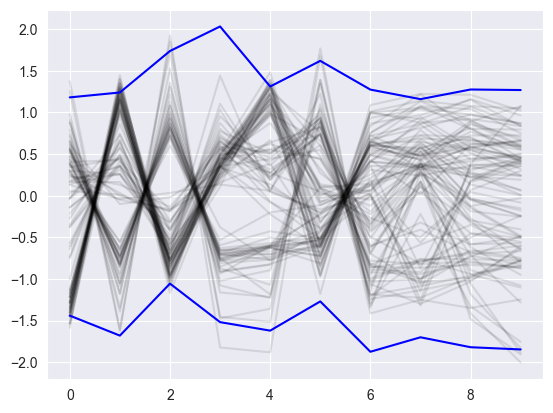

In [17]:
# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled.shape[1], 100, drift, dispersion, trained_score)

for l in samples:
    plt.plot(l, 'k', alpha = 0.1)

plt.plot(w_diffusion_scaled.min(0), 'b')
plt.plot(w_diffusion_scaled.max(0), 'b')


# Save for tikz
header = 'x'
for i in range(100):
    header = header + ' y' + str(i)
np.savetxt('tikz/fig_diagram_data/new_w_dist.csv', X=np.vstack([np.arange(10),samples]).T, delimiter=' ', comments='', header=header)

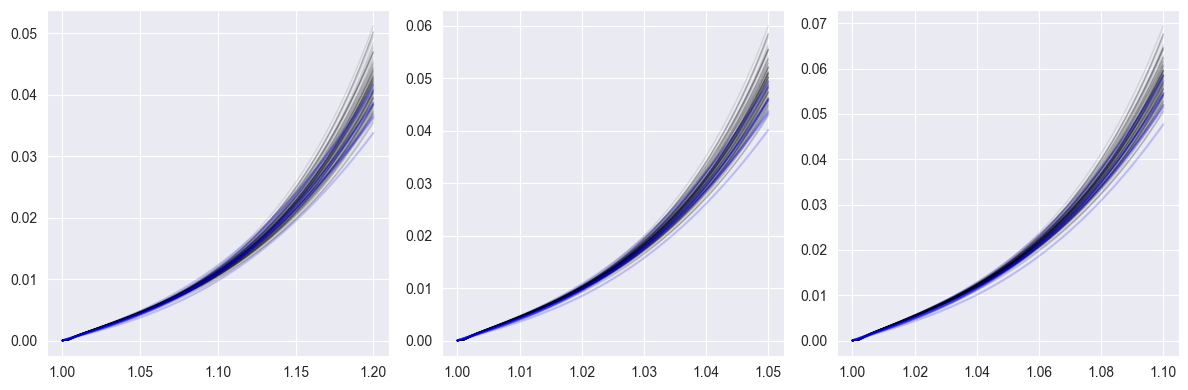

In [28]:
# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
for l in samples:
  l_unscaled = l*std_x+mu_x 
  l_full = jnp.concatenate((l_unscaled,w_diffusion[0,10:])) 
  sample_params = unravel_params(l_full)

  params_I1si,params_I2si, params_I1I2si = sample_params 
  params_I1 = (params_I1c, params_I1si)
  params_I2 = (params_I2c, params_I2si)
  params_I1I2 = (params_I1I2c, params_I1I2si, params_I1I2_a)

  mymodel = NODE_model(params_I1,params_I2,params_I1I2)
  sigx,sigy = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)
  
  axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
  axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
  axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)

for j in range(10):
    axs[0].plot(lam_vec[:50,1],       sigma_MR_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_MR_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_MR_s[j][0][2*50:3*50],color='b',alpha=0.2)

plt.tight_layout()
